In [1]:
# IMPORTS
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from skimage import morphology, filters, exposure, feature
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [23]:
# directories
base_dirs = ["./Training", "./Testing"]

# subfolders
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# labels
labels = {'glioma_tumor': 1, 'meningioma_tumor': 1, 'no_tumor': 0, 'pituitary_tumor': 1}

# Lists to store the images and labels
images = []
image_labels = []

# loop
for base_dir in base_dirs:
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for img_name in os.listdir(category_path): 
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')): # filter out non-image files
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path)
                img = img.resize((128, 128))  # resize images for uniformity
                img = np.array(img) # convert to array
                images.append(img)
                image_labels.append(labels[category])

# convert lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)


In [18]:
sum(image_labels==0)

500

In [24]:
# data augmentation

non_tumorous_images = images[image_labels == 0]

# define your data augmentation generator
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

# the .flow() method generates batches of augmented data
augmented_data = data_gen.flow(non_tumorous_images, batch_size=1)

# generate 3 times the amount of non-tumorous images
augmented_images = []
augmented_labels = []
for i in range(len(non_tumorous_images) * 2): 
    augmented_img = next(augmented_data)[0].astype('uint8')
    augmented_images.append(augmented_img)
    augmented_labels.append(0) 

# convert the lists 
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# combine
images = np.concatenate((images, augmented_images), axis=0)
image_labels = np.concatenate((image_labels, augmented_labels), axis=0)


In [26]:
sum(image_labels==0)

1500

In [27]:
# model
model = models.Sequential([
    # convolution layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# split to test vs train
X_train, X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42)

# normalise the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

c:\Users\alejo\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alejo\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alejo\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alejo\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

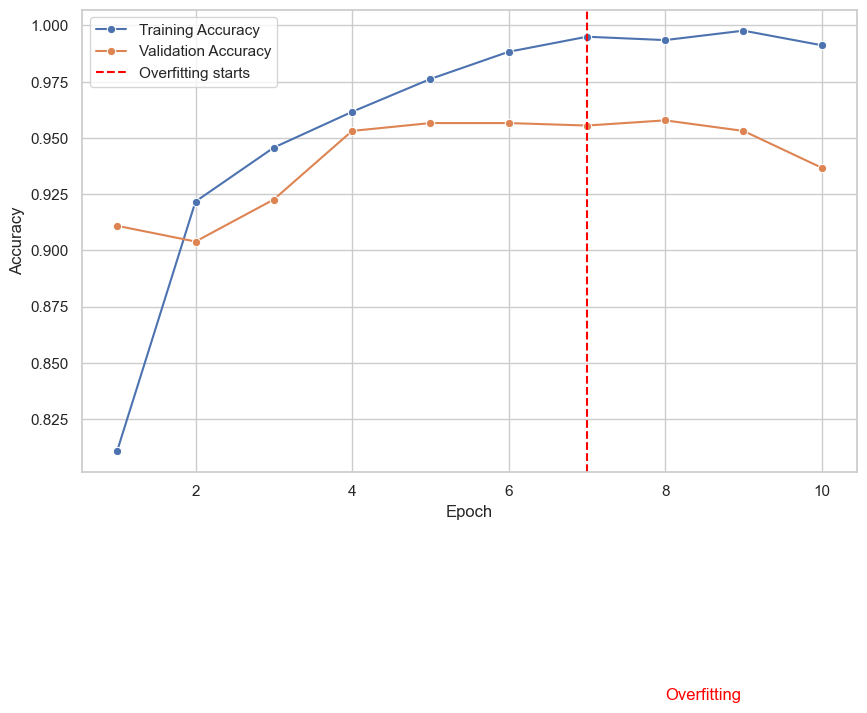

In [62]:

# copy data
history_data = {
    "Accuracy": [0.8109, 0.9217, 0.9457, 0.9616, 0.9762, 0.9883, 0.9950, 0.9935, 0.9977, 0.9912],
    "Validation Accuracy": [0.9109, 0.9039, 0.9226, 0.9531, 0.9566, 0.9566, 0.9555, 0.9578, 0.9531, 0.9367],
    "Epoch": list(range(1, 11))
}

df = pd.DataFrame(history_data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Epoch", y="Accuracy", label="Training Accuracy", marker="o")
sns.lineplot(data=df, x="Epoch", y="Validation Accuracy", label="Validation Accuracy", marker="o")
plt.axvline(x=7, color="red", linestyle="--", label="Overfitting starts")
plt.text(8, 0.7, 'Overfitting', color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

27/27 - 1s - loss: 0.2426 - accuracy: 0.9367 - 1s/epoch - 39ms/step
Test Loss: 0.24264606833457947
Test Accuracy: 0.9366940259933472


In [61]:
# calculate prediction
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.001).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# print
print(cm)


27/27 [==============================] - 1s 34ms/step
[[113 164]
 [  0 576]]


27/27 [==============================] - 1s 36ms/step


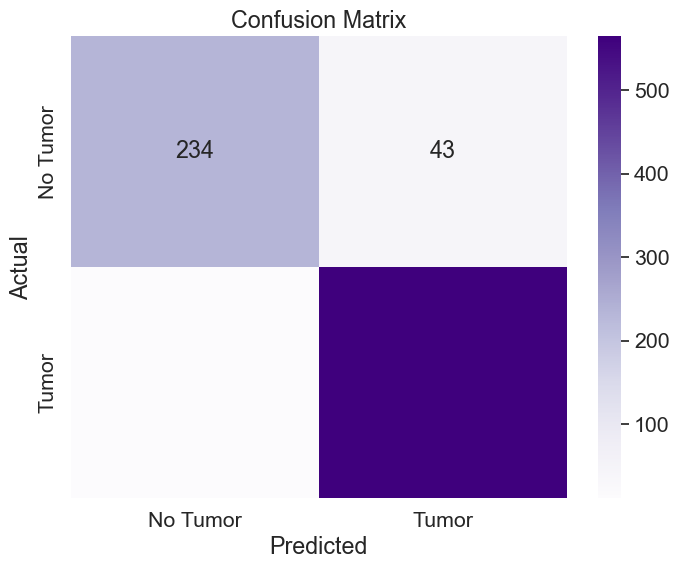

In [60]:
# plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [32]:
# model.save('differentmodel.h5')

In [35]:
# flatten the images for SVM and Linear Regression
X_train_flat = X_train.reshape((X_train.shape[0], -1)) 
X_test_flat = X_test.reshape((X_test.shape[0], -1)) 

# initialise the SVM model
svm_model = SVC(kernel='rbf', gamma='auto')

# fit
svm_model.fit(X_train_flat, y_train)

# make predictions on the flattened test data
svm_predictions = svm_model.predict(X_test_flat)


In [38]:
# confusion matrix
svm_cm = confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_cm)


SVM Confusion Matrix:
 [[133 144]
 [ 25 551]]


In [64]:
# initialise the Linear Regression model
linear_model = LinearRegression()

# fit the model
linear_model.fit(X_train_flat, y_train)

# predict on the test set
linear_predictions_continuous = linear_model.predict(X_test_flat)
linear_predictions = np.where(linear_predictions_continuous > 0.001, 1, 0)  # Apply threshold

# confusion matrix
logistic_cm = confusion_matrix(y_test, linear_predictions)
print("Logistic Regression Confusion Matrix:\n", logistic_cm)

Logistic Regression Confusion Matrix:
 [[111 166]
 [  5 571]]
